print?
np.*load*?
dir(np); help(np.log1p)

# 1. 데이터 불러오기 

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

pd.options.display.max_rows = 10

In [2]:
# seed
np.random.seed(601)
import random
random.seed(12345)

In [3]:
# 경로 확인
import os
os.getcwd() 

'C:\\Users\\okso6\\temp\\ADP'

## 데이터 불러오기
*  pd.read_csv('titanic_train.csv') : (Default) sep=','
*  pd.read_table('titanic_train.csv') : sep='\t'
*  pd.read_fwf('titanic_train.csv') : Fixed Width(고정길이) 기반 컬럼 포맷 

In [4]:
# txt = pd.read_csv('고객정보.txt', sep = "\t", , engine='python', encoding = "cp949")
train = pd.read_csv('titanic.csv', encoding='cp949')
# data = pd.concat((train, test)) # 병합 

### 기본 데이터 확인 

In [ ]:
print(train.shape)
print(train.columns)
train.head(2)

In [ ]:
train.describe()# include="all"

In [ ]:
# 타입 
train.info()
train.dtypes.value_counts()# normalize=False 개수, True 상대 비율

# 특정 타입 
col_type = train.dtypes[train.dtypes != 'object'].index
train[col_type].columns

# 중복
train.duplicated().sum(); train.drop_duplicates().shape

# 비율
train.survived.value_counts(normalize=True)

# 2. EDA & 전처리

## null 처리 

In [ ]:
display(train.isna().sum()) #  null 체크 

In [ ]:
import missingno
missingno.matrix(train, figsize = (5,3))

In [10]:
train['age'].fillna(train['age'].mean(),inplace=True)
train['cabin'].fillna('N',inplace=True)
train['fare'].fillna(0,inplace=True)
train['embarked'].fillna('N',inplace=True)
display(train.isna().sum().sum()) #  null 체크 

0

## outlier 

In [ ]:
for col in ['sibsp', 'parch']:
    plt.figure(figsize=(1,1))
    sns.boxplot(data=train[col])
    plt.title(col)
    plt.show()

In [ ]:
def get_outlier(df=None, column=None, weight=1.5):
    fraud = df[column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)

    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    
    return outlier_index

outlier_index = get_outlier(df=train, column='age', weight=1.5)
train_drop = train.drop(outlier_index, axis=0) # 행 
train.shape, train_drop.shape

## 전처리 

In [ ]:
## 정렬 
train.sort_values(by='age', ascending=True,inplace=False)

## group by 
agg_format={'age':['max','min'], 'fare':'mean'}
train.groupby('pclass').agg(agg_format)

## index
train_idx = train.reset_index(drop=True)#, inplace=False)
# 'ValueError: cannot reindex from a duplicate axis` 

## numpy

In [ ]:
np.where(1==1, 1, 0) # decode 
np.percentile(train.fare, 10) # 분위수: 하위 10% 90, 상위 10%
np.clip(np.array([1,2,3,4,5]), 2, 4) # min ~ max

### 문자열

In [ ]:
# 정규식 
train['Initial'] = train.name.str.extract('([A-Za-z]+)\.') # 추출 
train['name'].str[:2] # 앞에 2자, -1: 뒤에 1자  
train['name'].str.split(".")
train[train['name'].str.startswith("Zi")] # 시작글자 인식 endswith
train[train['name'].str.contains("Zi")] # 포함
train['name'].str.find(".") # 위치, 없으면 -1 rfind 
train['name'].str.findall('([A-Za-z]+)\.') # 정규식으로 찾은 모든 값 
train['name'].str.replace(" ", "_")
train['name'].str.pad(width=20, side='left', fillchar='0')
train['name'].str.strip()# 앞 뒤 공백 제거 
train['name'].str.lower()# upper swapcase
'123'.isdigit(), '123dd'.isdigit(), 'ddd'.isalpha(), '123dd'.isalpha()

train.cabin = train.cabin.str[:1]

In [ ]:
import math             
math.ceil(0.5) # 올림  
math.floor(0.5) # 내림

from statistics import mean
a=[5,2,3,2]
avg=mean(a)

In [ ]:
train['Initial'].replace(['Capt', 'Col', 'Countess', 'Don', 'Dona' , 'Dr', 'Jonkheer', 'Lady', 'Major', 'Master',  'Miss'  ,'Mlle', 'Mme', 'Mr', 'Mrs', 'Ms', 'Rev', 'Sir'], ['Sacrificed', 'Respected', 'Nobles', 'Mr', 'Mrs', 'Respected', 'Mr', 'Nobles', 'Respected', 'Kids', 'Miss', 'Nobles', 'Nobles', 'Mr', 'Mrs', 'Nobles', 'Sacrificed', 'Nobles'],inplace=True)
train['Initial'].replace(['Kids', 'Miss', 'Mr', 'Mrs', 'Nobles', 'Respected', 'Sacrificed'], [4, 4, 2, 5, 6, 3, 1], inplace=True)

In [ ]:
# age 구간화
"""
train['Age_cat'] = train['Age'].apply(lambda x : 'Child' if x<=15 
                                      else ('Adult' if x <= 60 
                                      else 'Elderly'))
                                      
train['Age_Range'] = pd.qcut(train['age'], 10)                                      
"""
train['age'] = (train.age*0.1).astype(int)
np.sort(train['age'].unique())

In [ ]:
# drop
train_drop = train.drop(['name','ticket'],axis=1) # 열 
train.shape, train_drop.shape

## 왜도 첨도 

In [ ]:
# 왜도 0 대칭 (-2~2) 
# -2 > 오른쪽으로 치우친(꼬리 왼쪽) Negative Skew  
# +2 < 왼쪽으로 치우친(꼬리 오른쪽) Positive Skew  
from scipy.stats import skew

skew_features = train[col_type].apply(lambda x : skew(x))

# skew 정도가 2 이상인 컬럼들만 추출. 
skew_features_top = skew_features[skew_features > 2]
print(skew_features_top.sort_values(ascending=False))

# 왜곡도가 1인 피처들은 로그 변환 적용하고 다시 하이퍼 파라미터 튜닝 후 재 학습/예측/평가
train[skew_features_top.index] = np.log1p(train[skew_features_top.index]) # expm1

In [ ]:
# Fisher=T         정규분포:0 0 > 뾰족 0 < 완만
# Fisher=F Pearson 정규분포:3 3 > 뾰족 3 < 완만
# 뾰족 Leptokurtic 분산도 작음(outlier 많음)
# 완만 Platykurtic 분산도 큼(집단 이질, 정규분포 확인)
from scipy.stats import kurtosis
kurt_features = train[col_type].apply(lambda x : kurtosis(x))
print(kurt_features.sort_values(ascending=False))

## 스케일링 & 정규화 

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

scaler = StandardScaler()
#scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(train[col_type])
#scaled_data = PolynomialFeatures(degree=2, include_bias=False).fit_transform(train)
scaled_df = pd.DataFrame(data=scaled_data, columns=col_type)
scaled_df.head(2) # train[col_type] = scaled_df[col_type]

## 시각화

<AxesSubplot:xlabel='survived', ylabel='age'>

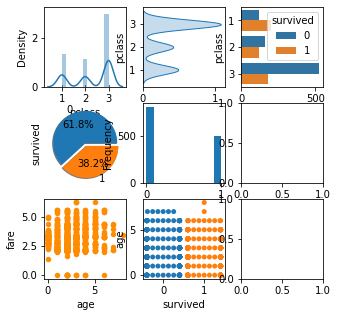

In [23]:
fig, ax = plt.subplots(3,3, figsize=(5,5))

sns.distplot(train['pclass'], ax=ax[0,0], kde=True, rug=True)
sns.kdeplot(y='pclass', data=train, shade=True, ax=ax[0,1])
sns.countplot(y='pclass', hue='survived', data=train, ax=ax[0,2])
train['survived'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[1,0], shadow=True)
train['survived'].plot.hist(ax=ax[1,1])
train.plot.scatter('age', 'fare', c="darkorange", ax=ax[2,0])
sns.swarmplot(x=train['survived'], y=train['age'], ax=ax[2,1])

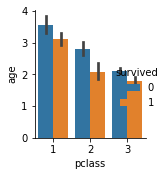

In [24]:
snsf = sns.factorplot(x='pclass', y='age', hue='survived', data=train, kind='bar')
snsf.fig.set_size_inches(2,2)

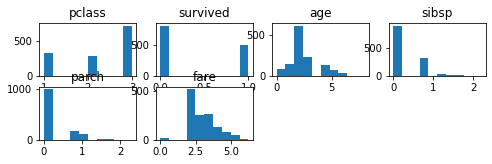

In [25]:
plt.figure(figsize=(8, 8))
for i, col in enumerate(list(col_type)):
    plt.subplot(7, 4, i + 1)
    plt.hist(train[col])
    plt.title(col)

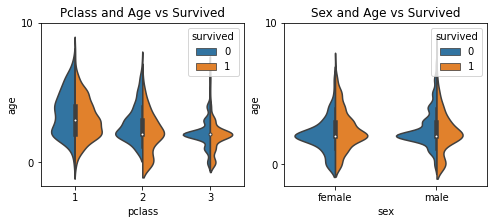

In [26]:
f, ax = plt.subplots(1,2,figsize=(8,3))
sns.violinplot("pclass", "age", hue="survived", data=train, split=True, ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0, 20, 10))
sns.violinplot("sex","age", hue="survived", data=train, split=True, ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0, 20, 10))
plt.show()

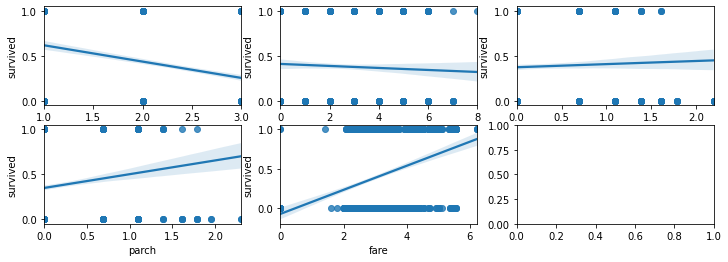

In [27]:
# 2개의 행과 4개의 열을 가진 subplots를 이용. axs는 4x2개의 ax를 가짐.
fig, axs = plt.subplots(figsize=(12,4) , ncols=3 , nrows=2)
lm_features = ['pclass','age','sibsp','parch','fare']
for i , feature in enumerate(lm_features):
    row = int(i/3)
    col = i%3
    # 시본의 regplot을 이용해 산점도와 선형 회귀 직선을 함께 표현
    sns.regplot(x=feature , y='survived',data=train , ax=axs[row][col])

In [ ]:
# 공분산 cov = 0 선형관계 X; 단위의 크기에 영향 => corr
# 상관관계 # 숫자형만 가능! 
plt.figure(figsize=(4, 4))
corr = train.corr() # method=pearson/kendall/spearman(rank)
sns.heatmap(corr, cmap='RdBu', annot=True, fmt='.1g')

# 차원축소
## PCA
* 입력 데이터의 변동성이 가장 큰 축을 구하고
* 그 축에 직각인 축을 반복적으로 축소하려는 차원 개수만큼 구해서 
* 입력 데이터를 새로운 차원에 투영


* 입력 데이터의 공분산 행렬을 기반으로 고유벡터를 생성하고
* 고유벡터에 데이터를 선현변환하는 방식

In [ ]:
from sklearn.decomposition import PCA # 숫자, not null

pca = PCA(n_components=2)

pca.fit(train[col_type])
pca_data = pca.transform(train[col_type])
print(pca_data.shape)

# 각 PCA Component별 변동성 비율
print(pca.explained_variance_ratio_) # explained_variance_

## LDA(Linear Discriminant Analysis)
* 지도학습의 분류에서 사용하기 쉽도록 개별 클래스를 분별할 수 있는 기준 최대한 유지
    * 클래스간 분산과 클래스 내부 분산의 비율 최대화

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
# col_type에 survived 제거 
lda.fit(train[['pclass','age','sibsp','parch','fare']], train.survived)
lda_data = lda.transform(train[['pclass','age','sibsp','parch','fare']])
print(lda_data.shape)

## SVD(Singular Value Decomposition): 특이값 분해 
* PCA 가 정방행렬만 가능한 반면 크기가 다른 행렬도 가능 
* PCA 가 밀집행렬에만 가능한 반면 SVD는 희소 행렬에도 가능 
* 토픽 모델링 기법 LSA(Latent Semantic Analysis)의 기반 알고리즘 
* 이미지 압축, 패턴 인식, 신호처리 분야 등 

In [ ]:
from sklearn.decomposition import TruncatedSVD

tsvd = TruncatedSVD(n_components=2)
tsvd.fit(train[col_type])
tsvd_tf = tsvd.transform(train[col_type])

## NMF(Non-Negative Matrix Factorization)
**모든 원소 값이 양수가 보장되면 사용할 수 있는 근사 행렬 분해**
* SVD와 유사
* SVD 활용 분야 + 추천 영역(잠재 요소 기반 추천 방식)

In [ ]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=2)

nmf.fit(train[col_type])
nmf_tf = nmf.transform(train[col_type])

## 군집

In [ ]:
from sklearn.cluster import KMeans, MeanShift, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score

In [ ]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300,random_state=0)
meanshift= MeanShift(bandwidth=0.9) # kmeans.cluster_centers_
gmm = GaussianMixture(n_components=3, random_state=0)
dbscan = DBSCAN(eps=0.6, min_samples=8, metric='euclidean')

train['cluster'] = kmeans.fit_predict(train[col_type])

silhouette_score(train[col_type], train['cluster']) # 0~1(1에 가까울수록 좋음)

## 범주형 데이터

In [ ]:
def cat_chk(col):
    print(col, train[col].nunique())
    #print(train[col].unique())
    #print(train[col].value_counts(), '\n')

cols = ['pclass','embarked','cabin']
for col in cols:
    cat_chk(col)

# 범주형 
train = pd.get_dummies(train, columns=cols)
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# LabelEncoder().fit_transform() .classes_ .inverse_transform
# pd.factorize() > return encoded, class, df['col'].factorize()[0]

In [ ]:
# .loc 값 변경 
train.loc[(train['sex'] == 'male'), 'sex'] = 1
train.loc[(train['sex'] == 'female'), 'sex'] = 2
train.loc[(train['age'] < 1), 'sex'] = 3

## datetime

In [ ]:
from datetime import datetime, timedelta
now = datetime.now()
print('now', now.year, now.month, now.day)
delta = datetime(2011,1,7) - datetime(2020,1,1, 15) # 시간차이 
print('delta', delta.days, delta.seconds)

# str -> datetime
stamp = datetime(2011,1,3, 13, 12, 55)
str(stamp)
stamp.strftime('%Y-%m-%d %H:%M:%S %w') # %w 요일[0 일요일]

from dateutil.parser import parse
parse('2011-01-01')

# dt['col1'] = dt.col1.apply(pd.to_datetime)
# df['year'] = df.datetime.apply(lambda x : x.year)

# 3. 모델 모델
**cross_val_score = KFold/StratifiedKFold + train_test_split + fit/predict/evaluation**

In [ ]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict

In [ ]:
col = list(set(train.columns) - set(['survived','name','ticket']))

col_o = train[col].dtypes[train[col].dtypes == 'object']
train[col_o.index] = train[col_o.index].astype(float)

## 데이터 분리

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train[col], train.survived
, test_size=0.3, random_state=12345, stratify=train.survived)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

n_iter = 0
for train_idx, test_idx in skf.split(train[col], train.survived):
    n_iter += 1; print(n_iter)
    #print('학습\n',train['survived'].iloc[train_idx].value_counts())
    #print('검증\n',train['survived'].iloc[test_idx].value_counts())

## 오버 샘플링

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
X_train.shape[0], X_train_over.shape[0], pd.Series(y_train_over).value_counts()

In [ ]:
#from imblearn.under_sampling import RandomUnderSampler
#X_resampled, y_resampled = RandomUnderSampler(random_state=0).fit_resample(X, y)

## 분류 

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier # 사이킷런 래퍼
from lightgbm import LGBMClassifier # 사이킷런 래퍼
from sklearn.linear_model import LogisticRegression # 분류, 희소 영역 분류, 텍스트 분류 
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [ ]:
dt_clf = DecisionTreeClassifier(criterion='gini', # 'entropy'
    splitter='best', # 'random'
    max_depth=5,min_samples_split=2,min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None, # 'auto' 'sqrt' 'log2'
    random_state=11,max_leaf_nodes=None)
dt_clf.fit(X_train , y_train)
dt_pred = dt_clf.predict(X_test)
#dt_clf.get_params()
rf_clf = RandomForestClassifier(random_state=11) 
gb_clf = GradientBoostingClassifier(random_state=0) 
ada_clf = AdaBoostClassifier(n_estimators=100)
knn_clf = KNeighborsClassifier(n_neighbors=8)
gnb = GaussianNB()
#------------------------------------------------------------#
evals = [(X_test, y_test)]

xgb_clf = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3, random_state=156
, min_child_weight=1, colsample_bytree=0.75, reg_alpha=0.03,  n_jobs=-1)
xgb_clf.fit(X_train , y_train,  early_stopping_rounds=400, eval_set=evals, eval_metric="logloss",  verbose=False)
xgb_pred = xgb_clf.predict(X_test)

lgbm_clf = LGBMClassifier(n_estimators=400, num_leaves=32, sumbsample=0.8, min_child_samples=100,
max_depth=128,  n_jobs=-1, boost_from_average=False)
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", 
eval_set=evals, verbose=False)

## 회귀

In [ ]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [ ]:
li_reg = LinearRegression(
    fit_intercept=True, # 절편값 계산, False: 절편 사용되지 않고 0 
    normalize=False, # fit_intercept=True 일때만 사용, 회귀 수행 전 정규화 수행
    copy_X=True,
    n_jobs=None,
)
li_reg.fit(X_train ,y_train) # .intercept_ np.round(li_reg.coef_, 1)

lo_reg = LogisticRegression()
lo_reg.fit(X_train ,y_train.astype('int'))

rf_reg = RandomForestRegressor(random_state=0, n_estimators=1000)
gb_reg = GradientBoostingRegressor(random_state=0, n_estimators=1000)
dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
rf_reg = RandomForestRegressor(random_state=0, n_estimators=1000)
xgb_reg = XGBRegressor(n_estimators=1000)
lgb_reg = LGBMRegressor(n_estimators=1000)

## 튜닝

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[1, 2], 'min_samples_split':[2,3]}
grid_dtree = GridSearchCV(dt_clf, param_grid=parameters, cv=3, refit=True, return_train_score=True)
grid_dtree.fit(X_train, y_train)
scores_df = pd.DataFrame(grid_dtree.cv_results_) # best_params_ # best_score_ 
scores_df[['params', 'mean_test_score', 'rank_test_score', 
           'split0_test_score', 'split1_test_score', 'split2_test_score']]
pred = grid_dtree.best_estimator_.predict(X_test)
#accuracy_score(pred, y_test)

In [ ]:
from bayes_opt import BayesianOptimization

bayes_params = {
    'num_leaves': (24, 45),
    'colsample_bytree':(0.5, 1), 
    'subsample': (0.5, 1),
    'max_depth': (4, 12),
    'reg_alpha': (0, 0.5),
    'reg_lambda': (0, 0.5), 
    'min_split_gain': (0.001, 0.1),
    'min_child_weight':(5, 50)
}

def lgb_roc_eval(num_leaves, colsample_bytree, subsample, max_depth, reg_alpha, reg_lambda, min_split_gain, min_child_weight):
    
    params = {
        "n_estimator":200,
        "learning_rate":0.02,
        'num_leaves': int(round(num_leaves)),
        'colsample_bytree': colsample_bytree, 
        'subsample': subsample,
        'max_depth': int(round(max_depth)),
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda, 
        'min_split_gain': min_split_gain,
        'min_child_weight': min_child_weight,
        'verbosity': -1
    }
    print("params:", params)
    lgb_model = LGBMClassifier(**params)
    lgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=30, eval_metric="auc", verbose=100 )
    best_iter = lgb_model.best_iteration_
    print('best_iter:', best_iter)
    valid_proba = lgb_model.predict_proba(X_test, num_iteration=best_iter)[:, 1]
    roc_preds = roc_auc_score(y_test, valid_proba)
    print('roc_auc:', roc_preds)
    return roc_preds
    
BO_lgb = BayesianOptimization(lgb_roc_eval, bayes_params, random_state=0, verbose=1)
"""
BO_lgb.maximize(init_points=5, n_iter=10)   
max_params = BO_lgb.max['params']
max_params['num_leaves'] = int(round(max_params['num_leaves']))
max_params['max_depth'] = int(round(max_params['max_depth'])) 
"""
print("max param 으로 재학습")

## 앙상블 

In [ ]:
from sklearn.ensemble import VotingClassifier

vo_clf = VotingClassifier( estimators=[('dt',dt_clf),('KNN',knn_clf)] , voting='soft' )
vo_clf.fit(X_train , y_train)
pred = vo_clf.predict(X_test)

# 4. 예측 및 평가 

## 분류 
* 오차행렬

# 사진



* 정밀도(Precision): Positive 예측 중 예측과 실제 Positive 일치 비율(양성 예측도)
    * 실제 Negative를 Positive로 잘못 판단하면 큰 영향이 미치는 경우(ex: 스팸메일)
    * FN: 실제 Positive 예측 Negative 를 낮추는데 초점
* 재현율(Recall): Positive 예측 중 실제 Positive 비율(민감도/TPR)
    * 실제 Positive를 Negative로 잘못 판단하면 큰 영향이 미치는 경우(ex: 암 판단)
    * FP: 실제 Positive 예측 Positive 를 낮추는데 초점
* F1 스코어: 정밀도/재현율 치우치지 않을수록 높게 나타남
* ROC AUC

* predict_proba(): 개별 데이터별로 예측 확률을 반환
    * 학습이 완료된 사이킷런 Classfier 객체에서 호출 가능

In [50]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, precision_recall_curve, f1_score, roc_curve, roc_auc_score

In [51]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # pred_proba: positive 확률 
    roc_auc = roc_auc_score(y_test, pred_proba, average='macro') # 'macro', 'weighted','samples' 
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

pred = dt_clf.predict(X_test)
pred_proba = dt_clf.predict_proba(X_test) 
get_clf_eval(y_test, pred, pred_proba[:,1].reshape(-1,1))

w_preds = xgb_clf.predict(X_test)
w_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]
get_clf_eval(y_test , w_preds, w_pred_proba)

l_preds = lgbm_clf.predict(X_test)
l_pred_proba = lgbm_clf.predict_proba(X_test)[:, 1]
get_clf_eval(y_test , l_preds, l_pred_proba)

[[227  16]
 [ 61  89]]
정확도: 0.8041, 정밀도: 0.8476, 재현율: 0.5933,    F1: 0.6980, AUC:0.8547
[[225  18]
 [ 53  97]]
정확도: 0.8193, 정밀도: 0.8435, 재현율: 0.6467,    F1: 0.7321, AUC:0.8799
[[224  19]
 [ 50 100]]
정확도: 0.8244, 정밀도: 0.8403, 재현율: 0.6667,    F1: 0.7435, AUC:0.8764


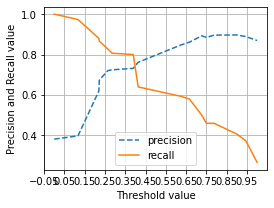

In [52]:
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.figure(figsize=(4,3))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],  label='recall')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel('Threshold value');
    plt.ylabel('Precision and Recall value');
    plt.legend();
    plt.grid();
    plt.show();
    
precision_recall_curve_plot(y_test, dt_clf.predict_proba(X_test)[:,1].reshape(-1,1))    

In [ ]:
def roc_curve_plot(y_test , pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환 받음. 
    fprs , tprs , thresholds = roc_curve(y_test ,pred_proba_c1)

    # ROC Curve를 plot 곡선으로 그림. 
    plt.plot(fprs , tprs, label='ROC')
    # 가운데 대각선 직선을 그림. 
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # FPR X 축의 Scale을 0.1 단위로 변경, X,Y 축명 설정등   
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()
    
roc_curve_plot(y_test, dt_clf.predict_proba(X_test)[:, 1] )

## 회귀 

In [54]:
from sklearn.metrics import mean_absolute_error, mean_squared_error , r2_score

In [55]:
# log 값 변환 시 언더플로우 영향으로 log() 가 아닌 log1p() 를 이용하여 RMSLE 계산
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_square_error() 를 이용하여 RMSE 계산
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

def mse(y,pred):
    return mean_squared_error(y,pred)

# 책에서는 mean_absolute_error()를 MSE로 잘못 기재함. 
# MAE, RMSE, RMSLE 를 모두 계산 
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    mse_val = mse(y,pred)
    # MAE 는 scikit learn의 mean_absolute_error() 로 계산
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}, MSE: {3:.3F}'.format(rmsle_val, rmse_val, mae_val, mse_val))
    
evaluate_regr(y_test, pred)

RMSLE: 0.307, RMSE: 0.443, MAE: 0.196, MSE: 0.196


## feature_importances
- negative 영향 feature 알 수 없음(불필요 변수 제거 도움 적음)

pclass_3 : 0.206
cluster : 0.000
cabin_D : 0.000


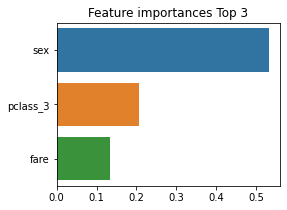

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

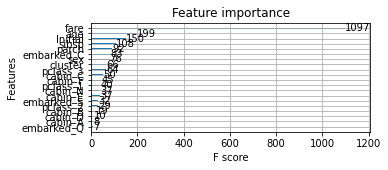

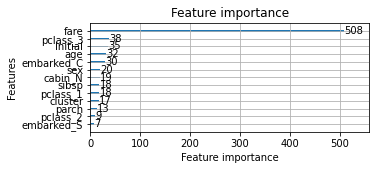

In [56]:
def vis_feature_importances_(est):
    ftr_importances_values = est.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
    ftr_top3 = ftr_importances.sort_values(ascending=False)[:3]
    plt.figure(figsize=(4,3))
    plt.title('Feature importances Top 3')
    sns.barplot(x=ftr_top3 , y = ftr_top3.index)
    plt.show()

# feature별 importance 매핑
for name, value in zip(col , dt_clf.feature_importances_[:3]):
    print('{0} : {1:.3f}'.format(name, value))

vis_feature_importances_(dt_clf)    

from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(5, 2))
# 사이킷런 래퍼 클래스를 입력해도 무방. 
plot_importance(xgb_clf, ax=ax)

from lightgbm import plot_importance

fig, ax = plt.subplots(figsize=(5, 2))
# 사이킷런 래퍼 클래스를 입력해도 무방. 
plot_importance(lgbm_clf, ax=ax)

In [ ]:
import eli5 # 학습 후 특정 변수 셔플 시, 성능으로 판단 
# 셔플 후, 성능 떨어지면 중요, 그대로거나 좋아지면 중요 X
from eli5.sklearn import PermutationImportance 
perm = PermutationImportance(dt_clf, scoring = "f1", random_state = 42).fit(X_train, y_train) 
eli5.show_weights(perm, top = 80, feature_names = col)
# eli5.explain_weights_df(perm, feature_names=col)

In [ ]:
df = pd.DataFrame(perm.results_, columns=col)
sns.boxplot(data=df).set(title='Perm', ylabel='Impor')           

# 5. 제출하기

In [59]:
#submission.to_csv('submission.csv', index=False)

## 파이썬 래퍼

In [ ]:
import xgboost as xgb

dtrain = xgb.DMatrix(data=X_train , label=y_train)
dtest = xgb.DMatrix(data=X_test , label=y_test)

params = { 'max_depth':3,
           'eta': 0.1,
           'objective':'binary:logistic',
           'eval_metric':'logloss',
           'early_stoppings':100
        }
num_rounds = 400

wlist = [(dtrain,'train'),(dtest,'eval') ]
xgb_model = xgb.train(params = params , dtrain=dtrain , num_boost_round=num_rounds , evals=wlist , verbose_eval=False)

pred_probs = xgb_model.predict(dtest)
print(np.round(pred_probs[:10],3))
preds = [ 1 if x > 0.5 else 0 for x in pred_probs ]
get_clf_eval(y_test , preds, pred_probs)

# 규제 

In [61]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV

In [62]:
# 릿지
ridge = Ridge(alpha = 10)
neg_mse_scores = cross_val_score(ridge, X_train, y_train, scoring="neg_mean_squared_error", cv = 5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

ridge = RidgeCV().fit(X_train, y_train)
importance = np.abs(ridge.coef_)

In [63]:
# 라쏘 
lasso = Lasso(alpha = 10)
lasso.fit(X_train, y_train)
pred = lasso.predict(X_test)

lasso = LassoCV().fit(X_train, y_train)
importance = np.abs(lasso.coef_)

<AxesSubplot:>

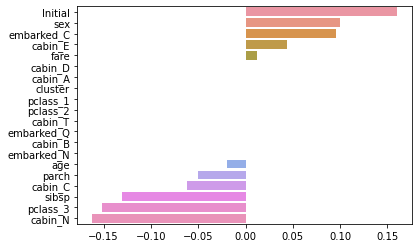

In [64]:
# 엘라스틱넷
elasticNet = ElasticNet(alpha = 10, l1_ratio=0.7)
elasticNet = ElasticNetCV().fit(X_train, y_train)

high = pd.Series(elasticNet.coef_, index=col).sort_values(ascending=False).head(10)
low = pd.Series(elasticNet.coef_, index=col).sort_values(ascending=False).tail(10)
con = pd.concat([high, low])

sns.barplot(x=con.values, y=con.index)

# AUTOML

In [ ]:
!pip install pycaret

from pycaret.classification import *

set_config('seed', 42)
clf = setup(session_id=42, data = train, target = 'voted'
, categorical_features=col_cat, numeric_features = [], ignore_features =[])

best_3 = compare_models(sort = 'AUC', n_select = 3)

blended = blend_models(estimator_list = best_3, fold = 5, method = 'soft')

pred_holdout = predict_model(blended)

final_model = finalize_model(blended)

predictions = predict_model(final_model, data = test)

submission['voted'] = predictions['Score']

# 정규식

In [1]:
import re

In [2]:
p = re.compile("[a-z]+") # [모든소문자] + 1번 이상 발생

In [3]:
print(p.match("a "))
print(p.match("a!"))
print(p.match("a23")) # 알파벳으로 시작만 하면("처음 위치!") 뒤에 뭐가 붙던 관계 없음 
print(p.match("1a"))

<re.Match object; span=(0, 1), match='a'>
<re.Match object; span=(0, 1), match='a'>
<re.Match object; span=(0, 1), match='a'>
None


In [4]:
print(p.search("a "))
print(p.search("a!"))
print(p.search("a23")) # 뭐가 앞 뒤로 붙어 있건 포함만 되면 됨 
print(p.search("123"))

<re.Match object; span=(0, 1), match='a'>
<re.Match object; span=(0, 1), match='a'>
<re.Match object; span=(0, 1), match='a'>
None


In [5]:
print(p.findall("a b"))
print(p.findall("a!bb b"))
print(p.findall("a23b12 ")) # 해당하는 연결을 리스트로 반환, 공백으로 구별이 되면 구분함 
print(p.findall("123"))

['a', 'b']
['a', 'bb', 'b']
['a', 'b']
[]


In [6]:
print(p.finditer("a b"))
print(p.finditer("a!bb b"))
print(p.finditer("a23b12 ")) # 해당하는 연결을 리스트로 반환, 공백으로 구별이 되면 구분함 
print(p.finditer("123"))

### 매치 객체 함수

In [7]:
m = p.search("456 python 123")

In [8]:
print(m.group())
print(m.start())
print(m.end())
print(m.span())

python
4
10
(4, 10)


### 그룹핑 (그룹핑할 패턴 묶기)

In [9]:
p = re.compile("\w+\s+\d+[-]\d+[-]\d+")
m = p.search("park 010-123-4567")
m

<re.Match object; span=(0, 17), match='park 010-123-4567'>

In [10]:
p = re.compile(r"\w+\s+\d+[-]\d+[-]\d+")
m = p.search("park 010-123-4567")
m

<re.Match object; span=(0, 17), match='park 010-123-4567'>

In [11]:
p = re.compile(r"(\w+)\s+((\d+)[-]\d+[-]\d+)")
m = p.search("park 010-123-4567")

print(m.group(0))
print(m.group(1))
print(m.group(2))
print(m.group(3)) # 중첩 시, 바깥부터 안으로 
# print(m.group(4))

park 010-123-4567
park
010-123-4567
010


### 전/후방탐색

In [12]:
p = re.compile(".+:")
m = p.search("http://google.com")
print(m)
print(m.group())

<re.Match object; span=(0, 5), match='http:'>
http:


In [13]:
p = re.compile(".+(?=:)")
m = p.search("http://google.com")
print(m)
print(m.group())

<re.Match object; span=(0, 4), match='http'>
http


In [14]:
p = re.compile(".*[.](?!bat|exe).*$") # 확장자 bat exe 제외 
print(p.search("abc.xslx"))
print(p.search("def.bat"))
print(p.search("gh0.exe"))

<re.Match object; span=(0, 8), match='abc.xslx'>
None
None


In [15]:
p = re.compile(".*[.](?!bat|exe)$") # 소비 안해서 마지막에 .*$ 필요 
print(p.search("abc.xslx"))
print(p.search("def.bat"))
print(p.search("gh0.exe"))

None
None
None


### 문자열 바꾸기

In [16]:
p = re.compile('(blue|white|red)')
print(p.sub('colour', 'blue socks and red shoes'))
print(p.sub('colour', 'blue socks and red shoes', count=1))

colour socks and colour shoes
colour socks and red shoes


### greedy non-greedy

In [17]:
s = '<html><head><title></title></head></html>'
print(re.match('<.*>', s)) # greedy

<re.Match object; span=(0, 41), match='<html><head><title></title></head></html>'>


In [18]:
s = '<html><head><title></title></head></html>'
print(re.match('<.*?>', s)) # non-greedy

<re.Match object; span=(0, 6), match='<html>'>


# 종합문제

In [19]:
s1 = "a:b:c:d"
p = re.compile(":")
p.sub("#", s1)

'a#b#c#d'

In [20]:
s19 = 'park 010-9999-9988'
p = re.compile("(\d+[-]\d+)[-]\d+") # 앞에 이름 부분 없어도 되네... 
m = p.search(s19)

p.sub("\g<1>-####", s19)

'park 010-9999-####'

In [21]:
s20 = 'park@naver.com'
p = re.compile('.*[@].*[.](?=com$|net$)\w+$')
m = p.search(s20)
print(m)

<re.Match object; span=(0, 14), match='park@naver.com'>


In [22]:
s21 = 'park@naver.co.kr'
p = re.compile('.*[@].*[.](?=com$|net$)\w+$')
m = p.search(s21)
print(m)

None
